In [8]:
#Matplotlib: #
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
#from sympy import *
#from sympy.abc import theta
from scipy.optimize import curve_fit
from numpy import genfromtxt

#Atropy: #
from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.wcs import WCS

In [10]:
# Por primeiro então partindo do site https://gea.esac.esa.int/archive/
# Temos que definir os seguintes parametros:
# Parametros ultilizados no site do Gaia 
#   1- Distances less than 500 pc; 
#   2- Glatitudes less than 2° in module; 
#   3- Parallax errors less than 2%; 
#   4- Proper motion errors less than 2%;
# O SQL ultilizado para buscar os dados foi:
#SELECT ra, dec, parallax, l, b, pm, pmra, pmdec 
#FROM gaiaedr3.gaia_source 
#WHERE parallax < 500 AND abs(b) < 2 AND ABS ( parallax_error/parallax ) < 2 AND ABS( pmra_error/pmra ) < 0.02 AND ABS ( pmdec_error/pmdec ) < 0.02

# Fazendo o load do arquivo em csv, baixo do gaia com os parametros acima
df = np.loadtxt('1649112049535O-result.csv', delimiter=',', skiprows= 1)
# Criando um cabeçalho, apenas para não se perder em qual coluna é qual
header = np.array(['ra', 'dec', 'parallax', 'l', 'b', 'pm', 'pmra', 'pmdec'])
print(header)
df

['ra' 'dec' 'parallax' 'l' 'b' 'pm' 'pmra' 'pmdec']


array([[285.45592632,   5.69851055,   2.51115178, ...,  11.044467  ,
          8.49585681,  -7.05695924],
       [285.49197522,   5.70366401,   5.68763924, ...,  78.9557    ,
         61.7329144 ,  49.22449368],
       [285.49043554,   5.72249192,   3.79215342, ...,  65.40521   ,
          4.45102449, -65.2535857 ],
       ...,
       [189.61027795, -61.47220431,   2.72621899, ...,  28.307728  ,
        -27.60199997,   6.28148604],
       [189.48134828, -61.47592389,   2.28878245, ...,   5.448966  ,
          3.46063833,  -4.20894428],
       [189.58735807, -61.4494575 ,   2.3810947 , ...,   9.959472  ,
         -9.06782865,  -4.11892639]])

In [11]:
# Como aqui desde o inicio vamos trabalhar com dados em arrays,
# Foi definido aqui uma variavel para cada coluna de dados do aquivo importado
ra = np.array(df[:, 0])
dec = np.array(df[:, 1])
parallax = np.array(df[:, 2])
l = np.array(df[:, 3])
b = np.array(df[:, 4])
pm = np.array(df[:, 5])
pmra = np.array(df[:, 6])
pmdec = np.array(df[:, 7])

# Antes de tudo então, pegando o valor da parallax e dividindo cada linha por 1000 achamos a nossa distancia (range) em parsec
distancia = np.divide(1000, parallax)
df = np.column_stack((df, distancia))

# Colocando os valores de l e b em radiano
b_rad = np.radians(b)
l_rad = np.radians(l)

df


array([[285.45592632,   5.69851055,   2.51115178, ...,   8.49585681,
         -7.05695924, 398.22363945],
       [285.49197522,   5.70366401,   5.68763924, ...,  61.7329144 ,
         49.22449368, 175.81987134],
       [285.49043554,   5.72249192,   3.79215342, ...,   4.45102449,
        -65.2535857 , 263.70241083],
       ...,
       [189.61027795, -61.47220431,   2.72621899, ..., -27.60199997,
          6.28148604, 366.80839037],
       [189.48134828, -61.47592389,   2.28878245, ...,   3.46063833,
         -4.20894428, 436.91352048],
       [189.58735807, -61.4494575 ,   2.3810947 , ...,  -9.06782865,
         -4.11892639, 419.97489704]])

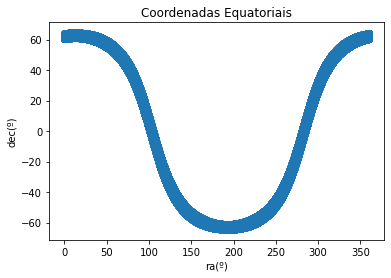

In [12]:
# Inicalmente vamos plotar aqui os dados das coordenadas equatorias
# No caso a assenção reta e declinação
plt.scatter(ra,dec)
plt.title("Coordenadas Equatoriais")
plt.xlabel("ra(º)")
plt.ylabel("dec(º)")
plt.show()

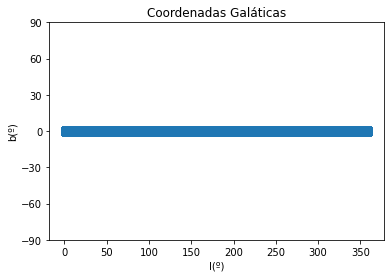

In [13]:
# Agora vamos plotar aqui os dados das coordenadas galaticas, pegando os valor direto do dados csv
plt.scatter(l , b)
plt.title("Coordenadas Galáticas")
plt.yticks(np.arange(-90,120,30))
plt.xlabel("l(º)")
plt.ylabel("b(º)")
plt.show()

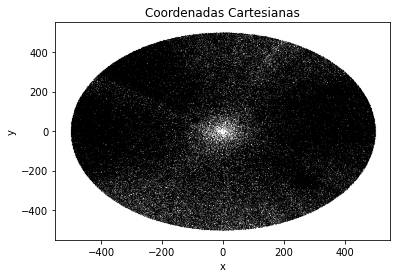

In [14]:
# Aqui vamos pegar a distancia com as coordenadas galaticas para coordenadas heliocêntricas, no caso x;y;z
#x= r.cosB.senl
x = distancia * np.cos(b_rad) * np.sin(l_rad)
#y= r.cosB.cosl
y = distancia * np.cos(b_rad) * np.cos(l_rad)
#z=r.senl
z = distancia * np.sin(b_rad)

# plt.scatter(x,y)
plt.scatter(x, y, color='black', s=0.005)
plt.title("Coordenadas Cartesianas")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

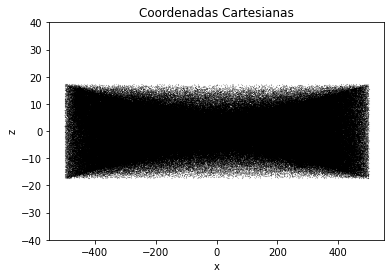

In [18]:
plt.scatter(x, z, color='black', s=0.005)
plt.yticks(np.arange(-40,50,10))
plt.title("Coordenadas Cartesianas")
plt.xlabel("x")
plt.ylabel("z")
plt.show()

In [19]:
#Movimento próprio:
#Selecionado um conjunto de estrelas á uma distancia de 100 parsec da terra#
df_distancia_100 = df[df[:,8] < 100]
df_distancia_100

array([[ 282.59675875,    3.8191889 ,   10.24715633, ...,   -8.48425835,
         -51.75608102,   97.58804958],
       [ 284.06315344,    4.81664986,   15.09393634, ...,  119.40363138,
        -303.18566202,   66.2517701 ],
       [ 284.33252068,    5.04140181,   10.83265461, ...,   34.49282726,
         -77.27662138,   92.3134759 ],
       ...,
       [ 191.4095772 ,  -60.98161293,   26.17528284, ...,  112.26602205,
         -65.64127623,   38.20398068],
       [ 294.0855764 ,   22.44234257,   20.46180296, ..., -286.66744201,
        -170.01663017,   48.8715487 ],
       [ 191.03577801,  -60.98161369,   11.98625458, ...,  -60.99105542,
          69.51818225,   83.42889707]])

In [20]:
# Ascensão reta = 192.86 (Constantes definidas) -> alpha = ra.rad 
alpha = np.radians(192.86)

# Declinação = 27.13 (Constantes definidas) -> delta = dec.rad
delta = np.radians(27.13)

# rotx = sen(delta).cos(dec) - cos(delta)*sen(dec)*cos(ra) - alpha
rotx = np.sin(delta)*np.cos(np.radians(df_distancia_100[:,1])) - np.cos(delta)*np.sin(np.radians(df_distancia_100[:,1]))*np.cos(np.radians(df_distancia_100[:,0]) - alpha)

# roty = cos(delta).sen(ra) - alpha
roty = np.cos(delta)*np.sin(np.radians(df_distancia_100[:,0]) - alpha)

#tendo o cos b
cosb = np.sqrt(rotx**2 + roty**2)

#movimento próprio para l
pml = 1/cosb * (rotx*df_distancia_100[:,6] + roty*df_distancia_100[:,7])

#Calculando a velocidae transversal v = du
velocidade = pml*df_distancia_100[:,8]*4.74047 / (np.cos(np.radians(df_distancia_100[:,4]))*1000)
velocidade

array([-23.12067392, -67.65162551, -23.20630938, ...,  20.60581473,
       -66.78118783, -24.90450637])

In [21]:
#fit e achando as constantes
variacao = 7.2
l1 = 0
l2 = variacao
lsample = []
vtsample = []

df_sample = np.column_stack((df_distancia_100, velocidade))

while l2 <= 360:

    filtro = np.logical_and(df_sample[:,3]>l1, df_sample[:,3]<l2)
    sample = df_sample[filtro]

    lsample.append(np.mean(sample[:,3]))
    vtsample.append(np.mean(sample[:,9]))

    l1 = l2
    l2 = l2 + variacao

def movimentoProprio(l, u0, v0):
    return -(u0*np.sin(np.radians(l)) + v0*np.cos(np.radians(l)))  

params, cov = curve_fit(movimentoProprio, lsample, vtsample)

u0   = params[0]
v0   = params[1]

xfit = np.linspace(0,360,100)
yfit = movimentoProprio(xfit, u0, v0)

Text(0, 0.5, 'vt')

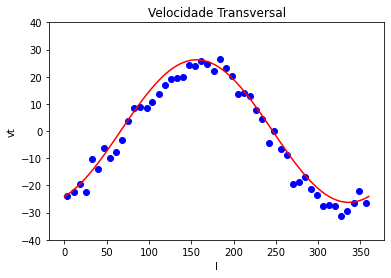

In [22]:
#Gráfico: #
fig, ax = plt.subplots()
plt.plot(lsample, vtsample, 'o', label='dados observacionais', color='blue')
plt.plot(xfit, yfit, label='u', color='red')
plt.title('Velocidade Transversal')
plt.yticks(np.arange(-40, 50, 10))
plt.xlabel('l')
plt.ylabel('vt')

In [23]:
# Calculado então a velocidade transversal dos dados, precisamos agora achas as constantes A e B
# Usando a mesma formula para rotação, porem agora considerando todas as distancias
new_rotx = np.sin(delta) * np.cos(np.radians(dec)) - np.cos(delta)*np.sin(np.radians(dec))*np.cos(np.radians(ra) - alpha)
new_roty = np.cos(delta)*np.sin(np.radians(ra) - alpha)
new_cosb = np.sqrt(new_rotx**2 + new_roty**2)

#movimento próprio para l
new_pml= 1/new_cosb * (new_rotx*pmra + new_roty*pmdec)

# calculo do movimento próprio
new_velocidade = 1000*(u0*np.sin(np.radians(l)) + v0*np.cos(np.radians(l)))/distancia
movimento = new_pml*4.74047/np.cos(np.radians(b)) + new_velocidade
#fit e achando as constantes

l1 = 0
l2 = 7.2
lsample = []
mplsample = []

new_df_sample = np.column_stack((df, movimento))

while l2 <= 360:

    filtro = np.logical_and(new_df_sample[:,3]>l1, new_df_sample[:,3]<l2)
    sample = new_df_sample[filtro]

    lsample.append(np.mean(sample[:,3]))
    mplsample.append(np.mean(sample[:,9]))

    l1 = l2
    l2 = l2 + variacao


def movimentoProprio(l, A, B):
    return A*np.cos(2*np.radians(l)) + B  

params, cov = curve_fit(movimentoProprio, lsample, mplsample)

A   = params[0]
B   = params[1]

xfit = np.linspace(0,360,100)
yfit = movimentoProprio(xfit, A, B)

print('A = %lf' %(A))
print('B = %lf' %(B))


A = 18.511736
B = -16.665410


Text(0, 0.5, '$\\mu_l$ (km s$^{-1}$ kpc$^{-1}$)')

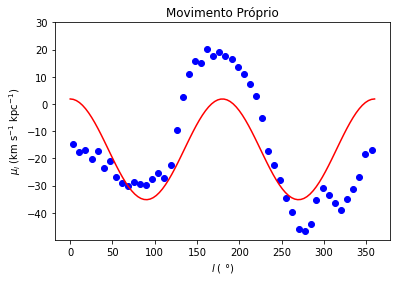

In [24]:
#Gráfico:
fig, ax = plt.subplots()
plt.plot(lsample, mplsample, 'o', label='dados observacionais', color='blue')
plt.plot(xfit, yfit, label='velociade transversal',color='red')
plt.title('Movimento Próprio')
plt.yticks(np.arange(-40, 40, 10))
plt.xlabel('$l$ ( °)')
plt.ylabel('$\mu_l$ (km s$^{-1}$ kpc$^{-1}$)')
